Dominik Wielath, Joule Voelz, Miguel Conner

# Text Mining Term Project

In [613]:
# import sys
# !{sys.executable} -m pip install textstat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

import re

In [614]:
stop_words = set(stopwords.words('english'))
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

# Load Data

## Join csv files

In [615]:
# df1 = pd.read_csv("all_articles_2015_2016.csv") #2015-2016
# df2 = pd.read_csv("all_articles_2017_2018.csv") #2017-2018
# df3 = pd.read_csv("all_articles_2019.csv") # 2020
# df4 = pd.read_csv("all_articles_2020.csv") # 2020
# df5 = pd.read_csv("all_articles_2021_2022.csv") # 2020

In [616]:
# df = pd.concat([df1, df2, df3, df4, df5])

In [617]:
# # Check that concatination worked correctly
# df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0] == df.shape[0]

In [618]:
# # Check that we have no duplicates
# df.drop_duplicates().shape[0] == df.shape[0]

In [619]:
# # Exclude rows with NaN in text column
# print(sum(df["story_text"].isna()))
# df = df.loc[~df["story_text"].isna(),]

In [620]:
# df.shape

In [621]:
# df.to_csv("all_data.csv")

In [622]:
df = pd.read_csv("all_data.csv") # 

## Some checks of data consistency

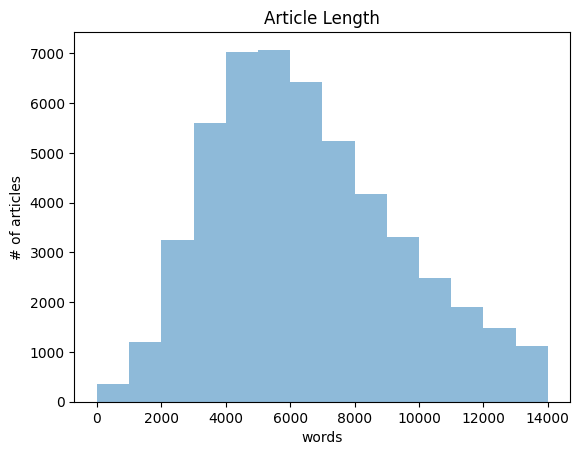

In [623]:
# Check to see distribution of lengths of articles.
length_data = [len(tex) for tex in df['story_text']]

# fixed bin size
bins = np.arange(-0, 15000, 1000) # fixed bin size

plt.hist(length_data, bins=bins, alpha=0.5)
plt.title('Article Length')
plt.xlabel('words')
plt.ylabel('# of articles')

plt.show()

In [624]:
df.head(2)

,Unnamed: 0.1,url,title,subtitle,n_sections,n_paragraphs,section_titles,story_text,claps,responses,reading_time,publication,date,year,Unnamed: 0
0,0,https://towardsdatascience.com/d3-js-the-custo...,D3.js —Use it as Custom modular Bundle Now!!,NaN,2,17,['D3.js —Use it as Custom modular Bundle Now!!...,It’s a Big Data world today and we deal with n...,133.0,2,3,Towards Data Science,2016-08-02,2016,NaN
1,1,https://towardsdatascience.com/machine-learnin...,Machine learning algorithm vs. Actuarial scien...,NaN,3,19,['Machine learning algorithm vs. Actuarial sci...,"In today’s fast paced world of technology, an ...",65.0,0,4,Towards Data Science,2016-08-05,2016,NaN


<AxesSubplot: >

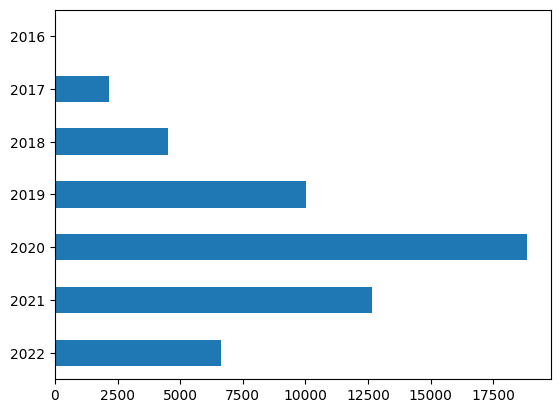

In [306]:
# Towards Data Science was launched on Medium on October of 2016, so we basically have all the data.
df.year.value_counts().sort_index(ascending=False).plot(kind = 'barh')

# Preprocessing

In [625]:
#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [626]:
#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==0:
                    stems.append(lowers)
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                stems.append(" ")
    return "".join(stems)

In [627]:
def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

In [628]:
# Exclude the row where story text only consists of NaN
print(df.shape)
df = df.loc[df.story_text.notna(),]
print(df.shape)

(54935, 15)
(54935, 15)


# Create text per month

In [629]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [630]:
df["month"] = df.date.dt.month
df["year"] = df.date.dt.year

In [631]:
df_month = df.groupby([df.year, df.month])['story_text'].apply(lambda x: ','.join(x)).reset_index()

In [495]:
# Create 
corpus = []
for i, text in enumerate(df_month.story_text):
    processed_text = tokenize(text, 1)
    corpus.append(processed_text)

KeyboardInterrupt: 

In [132]:
len(corpus)

24

## Create Word Count Matrix (Skip for now)

In [133]:
%%time
#build vocabulary
vocab, index = {}, 1  # start indexing from 1
for doc in corpus:
    #I added this line from lecture to add tokenization
    tokens = doc.split()
    for token in tokens:
        if token not in vocab:
            vocab[token] = index
            index += 1
        
vocab_stem=vocab
vocab_stem_size = len(vocab)
print(vocab_stem)
print(" ")
print("Total size of stemmed vocabulary:", vocab_stem_size)

{'late': 1, 'read': 2, 'machin': 3, 'learn': 4, 'kernel': 5, 'happen': 6, 'interest': 7, 'part': 8, 'classif': 9, 'problem': 10, 'go': 11, 'topic': 12, 'inspir': 13, 'medium': 14, 'post': 15, 'written': 16, 'alan': 17, 'nlp': 18, 'bot': 19, 'develop': 20, 'thank': 21, 'talk': 22, 'need': 23, 'understand': 24, 'term': 25, 'like': 26, 'svm': 27, 'support': 28, 'vector': 29, 'supervis': 30, 'blah': 31, 'mani': 32, 'right': 33, 'let': 34, 'discourag': 35, 'knew': 36, 'noth': 37, 'diy': 38, 'exercis': 39, 'walk': 40, 'togeth': 41, 'exact': 42, 'ml': 43, 'well': 44, 'turn': 45, 'actual': 46, 'lot': 47, 'thing': 48, 'overarch': 49, 'theme': 50, 'best': 51, 'sum': 52, 'oft': 53, 'quot': 54, 'statement': 55, 'made': 56, 'arthur': 57, 'samuel': 58, 'way': 59, 'back': 60, 'field': 61, 'studi': 62, 'give': 63, 'comput': 64, 'abil': 65, 'without': 66, 'explicit': 67, 'program': 68, 'said': 69, 'experi': 70, 'e': 71, 'respect': 72, 'task': 73, 'perform': 74, 'measur': 75, 'p': 76, 'improv': 77, 'tom

In [140]:
vectors=[]
for doc in corpus:
    vectors.append(vectorize(doc, vocab_stem))

KeyboardInterrupt: 

In [ ]:
word_counts = pd.DataFrame(vectors)

In [ ]:
word_counts.head()

# TF-IDF

In [20]:
cv = TfidfVectorizer(ngram_range = (2,2),norm=None)
cv.fit(corpus)
vectorized_text=cv.transform(corpus)

NameError: name 'corpus' is not defined

In [ ]:
vectorized_text

In [ ]:
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

In [ ]:
tfidf = pd.DataFrame(vectorized_text)
tfidf.columns = cv.get_feature_names_out()

In [ ]:
tfidf_t = tfidf.T

In [ ]:
tfidf_t[2].sort_values(ascending=False)

In [ ]:
for i in range(5):
    print(sum(tfidf_t[i]))
    print(tfidf_t[i+1].sort_values(ascending=False).head(25).index[~ tfidf_t[i+1].sort_values(ascending=False).head(25).index.isin(tfidf_t[i].sort_values(ascending=False).head(25).index)])

In [ ]:
tfidf_neural_network = tfidf["neural network"]

# Create the line plot
fig, ax = plt.subplots()
tfidf_neural_network.plot.line(ax=ax)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'neural network' (01.2017 to 12.2018)")
plt.show()

## LDA

In [632]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')

docs = df['story_text'] # map(unicode, df['original_text'])

[nltk_data] Downloading package wordnet to /Users/Miguel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [633]:
# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/198452781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = docs[idx].lower()  # Convert to lowercase.
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/198452781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.


In [23]:
# # Lemmatize the documents.
# from nltk.stem.wordnet import WordNetLemmatizer

# lemmatizer = WordNetLemmatizer()
# docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [635]:
# Stem documents (to compare preprocessing)

docs = [[porter.stem(token) for token in doc] for doc in docs] 

In [636]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [637]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [638]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [639]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 22103
Number of documents: 54935


In [640]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [641]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.1255.


In [642]:
# visualize the topics with a dataframe

avg_score = []
topic_list = []
for topic in top_topics:
    topic_i = []
    avg_score.append(topic[1])
    for word in topic[0]:
        topic_i.append(word[1])
    topic_list.append(topic_i)       

In [643]:
df_tops  = pd.DataFrame(topic_list)
df_tops.insert(0, "avg_score", avg_score)
df_tops.to_csv("LDA_topics.csv")
df_tops

,avg_score,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,-0.841463,me,thing,re,think,don,ve,good,could,peopl,...,tri,question,had,might,someth,lot,scienc,realli,say,cours
1,-0.907605,product,scienc,busi,compani,scientist,team,engin,user,custom,...,project,develop,tool,manag,solut,build,ml,problem,requir,job
2,-0.945075,imag,train,network,layer,neural,input,neural_network,deep,output,...,dataset,comput,loss,deep_learn,featur,object,architectur,weight,size,transform
3,-1.011095,distribut,sampl,variabl,probabl,test,point,linear,estim,random,...,calcul,statist,paramet,observ,error,method,optim,problem,algorithm,equat
4,-1.039048,ai,system,human,research,comput,world,state,algorithm,inform,...,been,develop,bias,studi,technolog,may,were,artifici,peopl,decis
5,-1.090431,featur,predict,dataset,train,class,test,machin_learn,tree,algorithm,...,classifi,classif,metric,accuraci,label,valid,decis,evalu,method,split
6,-1.129407,file,run,instal,python,api,command,project,packag,app,...,contain,notebook,user,librari,step,github,applic,version,deploy,cloud
7,-1.196930,plot,visual,seri,time_seri,chart,analysi,dataset,show,forecast,...,year,averag,below,color,map,point,line,variabl,day,month
8,-1.435335,column,python,tabl,list,method,type,panda,row,object,...,name,queri,return,oper,call,sql,array,string,index,element
9,-1.658987,word,text,cluster,graph,languag,embed,node,similar,vector,...,state,token,topic,algorithm,document,sequenc,action,task,gpt,nlp


The function below will give us the top topic of each document as well as the share of that topic. Put this into a dataframe which we will groupby to make into pretty plots.

In [644]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=docs)

# Make a new dataframe with our results.
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/1361661646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.4507,"file, run, instal, python, api, command, proje...","[it, big, data, world, today, and, we, deal, w..."
1,1,5,0.6823,"product, scienc, busi, compani, scientist, tea...","[in, today, fast, pace, world, of, technolog, ..."
2,2,8,0.6881,"plot, visual, seri, time_seri, chart, analysi,...","[in, this, analysi, explor, the, averag, tempe..."
3,3,6,0.4069,"me, thing, re, think, don, ve, good, could, pe...","[this, week, gave, talk, entitl, intro, to, ma..."
4,4,0,0.4126,"imag, train, network, layer, neural, input, ne...","[from, the, barren, landscap, insid, our, pers..."
5,5,1,0.6970,"ai, system, human, research, comput, world, st...","[find, sustain, solut, by, shift, from, suppli..."
6,6,8,0.4486,"plot, visual, seri, time_seri, chart, analysi,...","[this, morn, read, an, interest, articl, on, q..."
7,7,2,0.2909,"column, python, tabl, list, method, type, pand...","[this, blog, post, primarili, written, by, my,..."
8,8,1,0.4122,"ai, system, human, research, comput, world, st...","[the, world, is, explod, with, data, it, now, ..."
9,9,1,0.7082,"ai, system, human, research, comput, world, st...","[as, passion, comput, scientist, and, futurist..."


In [645]:
# Add our new data to our original dataframe.
df['dominant_topic'] = df_dominant_topic['Dominant_Topic']
df['keywords'] = df_dominant_topic['Keywords']

In [646]:
# This performs a groupby of our dataframe and aggregates our data by year, month and topic so that we
# can make some pretty plots.

df2 = df.groupby(['year', 'month', 'dominant_topic','keywords'])['story_text'].agg('count').reset_index()
df2 = df2[['year','month','dominant_topic', 'story_text', 'keywords']]
total_per_month = df.groupby(['year', 'month'])['story_text'].agg('count').reset_index()
total_per_month['story_text']
df3 = df2.merge(total_per_month, on=['year','month'], how='left', indicator=True)
df3['top_prop'] = [df3['story_text_x'][i]/df3['story_text_y'][i] for i in range(len(df3))]
df3

,year,month,dominant_topic,story_text_x,keywords,story_text_y,_merge,top_prop
0,2016,8,0,1,"imag, train, network, layer, neural, input, ne...",11,both,0.090909
1,2016,8,1,3,"ai, system, human, research, comput, world, st...",11,both,0.272727
2,2016,8,2,1,"column, python, tabl, list, method, type, pand...",11,both,0.090909
3,2016,8,3,1,"file, run, instal, python, api, command, proje...",11,both,0.090909
4,2016,8,5,2,"product, scienc, busi, compani, scientist, tea...",11,both,0.181818
...,...,...,...,...,...,...,...,...
730,2022,12,5,45,"product, scienc, busi, compani, scientist, tea...",382,both,0.117801
731,2022,12,6,23,"me, thing, re, think, don, ve, good, could, pe...",382,both,0.060209
732,2022,12,7,51,"distribut, sampl, variabl, probabl, test, poin...",382,both,0.133508
733,2022,12,8,23,"plot, visual, seri, time_seri, chart, analysi,...",382,both,0.060209


## LDA Plots

The plots below are made from assigning one topic to every article; specifically the topic with the largest share.

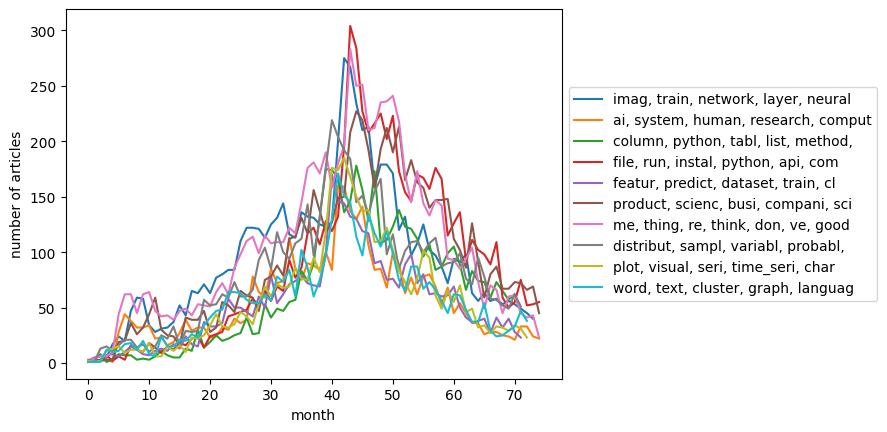

In [647]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(0,10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().story_text_x,
            label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("number of articles")
ax.legend(loc='best')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The plot below takes into account the number of articles per month, so we can compare which topics make a greater share of articles per month. Below, we have applied a smoothing of 12 months.

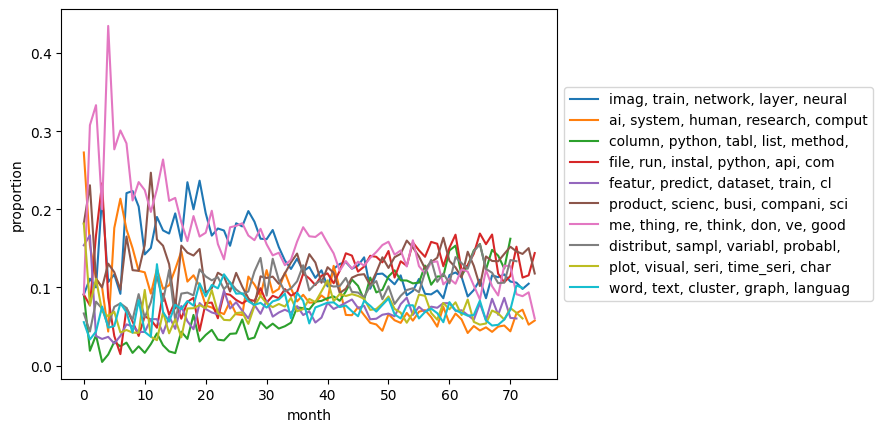

In [648]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/2515829200.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['_merge', 'keywords'], dtype='object')
  ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/2515829200.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['_merge', 'keywords'], dtype='object')
  ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/2515829200.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is de

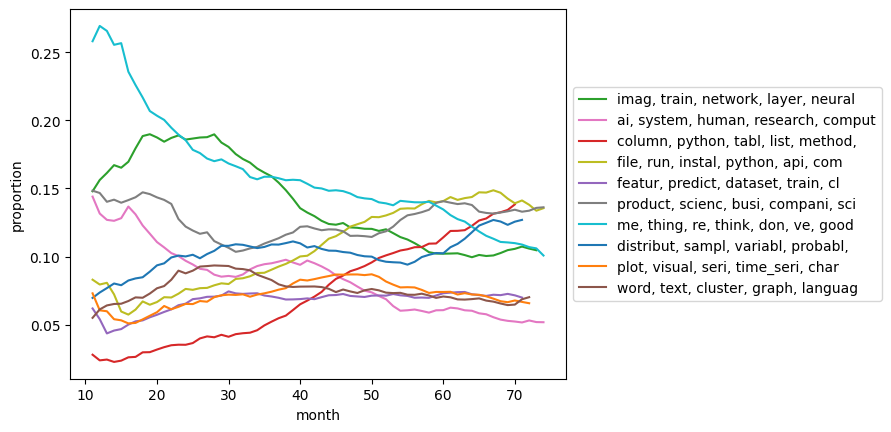

In [666]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

colors = ['#2ca02c', '#e377c2', '#d62728', 
          '#bcbd22','#9467bd','#7f7f7f', 
          '#17becf','#1f77b4','#ff7f0e', '#8c564b'
           ]

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,
            label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35],
            color=colors[top]
           )

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Regression

In [502]:
from textstat import flesch_reading_ease

In [516]:
# Compute difficulty of each article using the Flesch Reading Score.
# takes a few minutes
df['FRE']=df['story_text'].apply(lambda x : flesch_reading_ease(x))

In [517]:
# Prepare variables for regression

# count words in title and article
df['title_len'] = df['title'].apply(lambda x : len(x))
df['art_len'] = df['story_text'].apply(lambda x : len(x))
df["claps"] = df["claps"].replace(np.nan, 0)

# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['year'],dtype=np.int64)

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

In [518]:
# REGRESSION

# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len',0,1,2,3,4,5,6,7,8,9,
            2016,2017,2018,2019,2020,2021,2022]
df_4_reg = df_4_reg[reg_vars]

import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients

r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.6138228776245271


/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [519]:
regression_results = pd.DataFrame({'var': reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results

,var,coefs
0,n_paragraphs,-0.081632
1,n_sections,2.750407
2,FRE,-1.386116
3,title_len,-0.429957
4,responses,117.506431
5,art_len,0.003114
6,0,20.871820
7,1,-44.801781
8,2,-0.260460
9,3,23.374985


# Regression - testing

Try to look at the interaction terms of years and topics.

In [600]:
# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['year'],dtype=np.int64)

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

In [601]:
testdf = df_4_reg

In [602]:
for i in range(0,9):
    for j in range(2016, 2023):
        testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

In [611]:
# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len']
interaction_terms = list(testdf.columns[38:len(testdf.columns)])


df_4_reg = df_4_reg[interaction_terms+reg_vars]


In [609]:
import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients



(130.6307181788475,
 array([-2.66274893e+02,  9.29870764e+01,  3.21935126e+02, -5.08617777e+00,
        -3.67090827e+01, -7.15732459e+01, -8.28258446e+01, -5.03894654e+01,
        -8.16679744e+01, -9.25388503e+00, -4.78147493e+01, -9.48409601e+01,
        -7.81919379e+01, -8.43771826e+01, -4.42239125e+02,  3.98770067e+01,
         1.60540731e+02, -3.05814545e+01, -5.43824685e+01, -5.42833395e+01,
        -5.10822752e+01, -9.66338121e-13,  3.86697167e+01,  2.20335698e+02,
         4.14903030e+01, -1.80214771e+01, -6.54078314e+01, -8.57859429e+01,
        -1.82161391e+02, -9.98003832e+00,  3.20601178e+02,  2.79547397e+01,
        -4.61238754e+01, -6.12760737e+01, -7.52526673e+01,  3.01732349e+00,
        -8.55840501e+01,  2.07527778e+01, -1.48071202e+01, -4.84940107e+01,
        -7.11950026e+01, -7.78097234e+01, -3.55212468e+01, -7.92594532e+01,
         9.44060721e+01, -2.66502769e+01, -5.07385839e+01, -1.05770345e+02,
        -2.25392505e+02, -2.49059028e+02,  2.41240340e+01,  3.431051

In [610]:
r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

regression_results = pd.DataFrame({'var': interaction_terms+reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results

coefficient of determination: 0.6131792085542904


,var,coefs
0,0.2016,-266.274893
1,0.2017,92.987076
2,0.2018,321.935126
3,0.2019,-5.086178
4,0.2020,-36.709083
...,...,...
64,n_sections,2.372500
65,FRE,-1.386559
66,title_len,-0.437412
67,responses,117.959589
